In [ ]:
# Importações
# Modelo LSTM
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM,Dropout
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [84]:
dataframe_dados = pd.read_csv("DadosBitcoin.csv")

dataframe_dados['Data'] = pd.to_datetime(dataframe_dados['Data'], format="%d.%m.%Y")

dataframe_dados = dataframe_dados.sort_values(by='Data')

#dataframe_dados

In [83]:
dataframe_dados_selecionados = dataframe_dados[['Data', 'Último']]
dataframe_dados_selecionados = dataframe_dados_selecionados.set_index(pd.DatetimeIndex(dataframe_dados_selecionados['Data'].values))
dataframe_dados_selecionados.drop('Data', axis = 1,inplace = True)
dataframe_dados_selecionados['Último'] = dataframe_dados_selecionados['Último'].apply(lambda x: float(x.replace(".","").replace(",",".")))
#dataframe_dados_selecionados

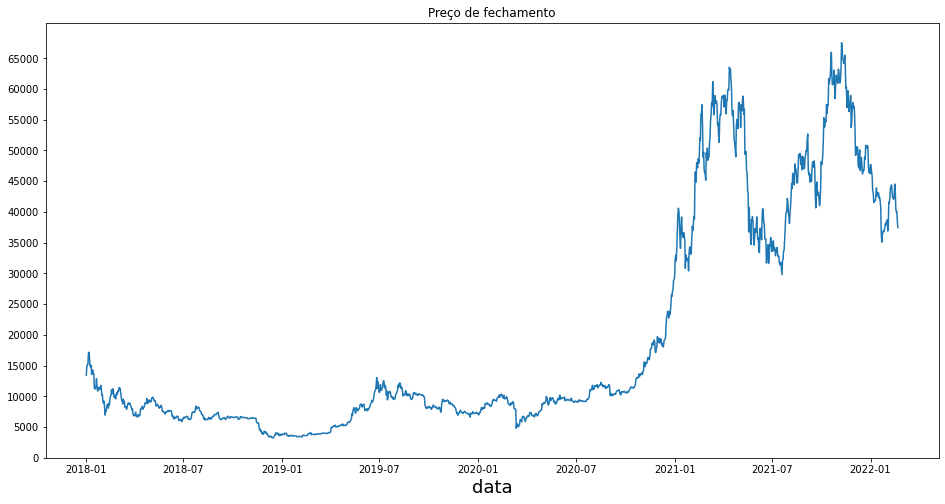

In [80]:
# plotar informações

plt.figure(figsize=(16,8))
plt.title('Preço de fechamento')
plt.plot(dataframe_dados_selecionados['Último'])
plt.xlabel('data',fontsize=18)
plt.yticks(np.arange(0, max(dataframe_dados_selecionados['Último']), 5000))
plt.show()

In [82]:
# quantidade de linhas 

quantidade_linhas = len(dataframe_dados_selecionados)

quantidade_linhas_treino = round(.70 * quantidade_linhas)

quantidade_linhas_teste = quantidade_linhas - quantidade_linhas_treino

info = ( 
    f"linhas treino = 0:{quantidade_linhas_treino}"
    f" linhas teste = {quantidade_linhas_treino}:{quantidade_linhas_treino + quantidade_linhas_teste}"
)

info

'linhas treino = 0:1059 linhas teste = 1059:1513'

In [86]:
# normalização dos dados
scaler = StandardScaler()
df_scaled = scaler.fit_transform(dataframe_dados_selecionados)

In [90]:
# separar em treino e teste
treino = df_scaled[:quantidade_linhas_treino]
teste = df_scaled[quantidade_linhas_treino: quantidade_linhas_treino + quantidade_linhas_teste]

In [88]:
# converter um array de valores em um dataframe matriz
def converte_array(dataframe, steps=1):
  dataX, dataY = [], []
  for x in range(len(dataframe)-steps-1):
    var = dataframe[x:(x+steps), 0]
    dataX.append(var)
    dataY.append(dataframe[x + steps, 0])
  return np.array(dataX), np.array(dataY)


In [92]:
# gerando dados de treino e teste
steps = 10
x_treino, y_treino = converte_array(treino, steps)
x_teste, y_teste = converte_array(teste, steps)

print(x_treino.shape)
print(y_treino.shape)
print(x_teste.shape)
print(y_teste.shape)

(1048, 10)
(1048,)
(443, 10)
(443,)


In [93]:
# gerando os dados que o modelo espera
x_treino = x_treino.reshape(x_treino.shape[0], x_treino.shape[1], 1)
x_teste = x_teste.reshape(x_teste.shape[0], x_teste.shape[1], 1)

In [95]:
# montando a rede neural
modelo = Sequential()
modelo.add(LSTM(35, return_sequences=True, input_shape=(steps, 1)))
modelo.add(LSTM(35, return_sequences=True))
modelo.add(LSTM(35))
modelo.add(Dropout(0.2))
modelo.add(Dense(1)) # saida

In [96]:
modelo.compile(optimizer="adam", loss="mse")
modelo.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 35)            5180      
                                                                 
 lstm_1 (LSTM)               (None, 10, 35)            9940      
                                                                 
 lstm_2 (LSTM)               (None, 35)                9940      
                                                                 
 dropout (Dropout)           (None, 35)                0         
                                                                 
 dense (Dense)               (None, 1)                 36        
                                                                 
Total params: 25,096
Trainable params: 25,096
Non-trainable params: 0
_________________________________________________________________


In [101]:
# treinamento do modelo 
validacao = modelo.fit(x_treino, y_treino, validation_data=(x_teste, y_teste), epochs=100 , batch_size=10 , verbose=2)

Epoch 1/100
105/105 - 9s - loss: 0.0371 - val_loss: 1.4803 - 9s/epoch - 82ms/step
Epoch 2/100
105/105 - 2s - loss: 0.0060 - val_loss: 1.3976 - 2s/epoch - 15ms/step
Epoch 3/100
105/105 - 2s - loss: 0.0056 - val_loss: 1.3215 - 2s/epoch - 16ms/step
Epoch 4/100
105/105 - 2s - loss: 0.0050 - val_loss: 1.2924 - 2s/epoch - 15ms/step
Epoch 5/100
105/105 - 2s - loss: 0.0050 - val_loss: 1.2358 - 2s/epoch - 15ms/step
Epoch 6/100
105/105 - 2s - loss: 0.0048 - val_loss: 1.2095 - 2s/epoch - 15ms/step
Epoch 7/100
105/105 - 2s - loss: 0.0045 - val_loss: 1.1294 - 2s/epoch - 15ms/step
Epoch 8/100
105/105 - 2s - loss: 0.0055 - val_loss: 1.0496 - 2s/epoch - 15ms/step
Epoch 9/100
105/105 - 2s - loss: 0.0042 - val_loss: 1.0013 - 2s/epoch - 15ms/step
Epoch 10/100
105/105 - 2s - loss: 0.0050 - val_loss: 0.9502 - 2s/epoch - 15ms/step
Epoch 11/100
105/105 - 2s - loss: 0.0049 - val_loss: 0.8281 - 2s/epoch - 15ms/step
Epoch 12/100
105/105 - 2s - loss: 0.0040 - val_loss: 0.7884 - 2s/epoch - 17ms/step
Epoch 13/100


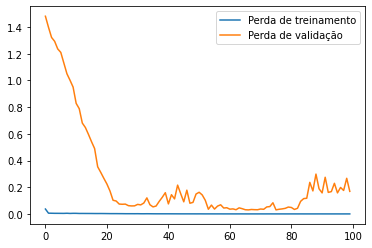

In [103]:
# visualizar do treinamento
plt.plot(validacao.history['loss'], label='Perda de treinamento')
plt.plot(validacao.history['val_loss'], label='Perda de validação')
plt.legend()

In [104]:
# Fazendo a Previsão
previsao = modelo.predict(x_teste)
previsao = scaler.inverse_transform(previsao)
previsao

array([[18951.12 ],
       [19088.793],
       [19347.164],
       [19297.73 ],
       [18647.443],
       [18551.3  ],
       [18348.133],
       [18117.863],
       [18612.305],
       [19088.898],
       [19311.166],
       [19471.83 ],
       [20795.172],
       [22299.283],
       [23080.492],
       [23721.287],
       [23748.04 ],
       [23230.367],
       [23606.896],
       [23543.623],
       [23746.146],
       [24398.16 ],
       [25649.02 ],
       [26205.852],
       [26737.602],
       [27139.18 ],
       [27976.512],
       [28503.912],
       [28876.809],
       [30111.549],
       [31222.768],
       [31477.51 ],
       [32057.29 ],
       [33279.883],
       [34807.23 ],
       [36109.453],
       [36804.46 ],
       [36628.312],
       [35536.406],
       [34154.176],
       [34204.4  ],
       [35067.195],
       [35272.758],
       [34914.69 ],
       [34509.098],
       [34465.137],
       [34379.684],
       [34147.51 ],
       [32449.77 ],
       [31894.818],


In [106]:
# previsão para os proximos 10 dias 
lenght_teste = len(teste)
lenght_teste

454

In [107]:
# pegar os ultimos dias que sao o tamanho do meu step
dias_input_steps = lenght_teste - steps
dias_input_steps

444

In [108]:
# transformando em array
input_steps = teste[dias_input_steps:]
input_steps = np.array(input_steps).reshape(1, -1)
input_steps

array([[1.2856609 , 1.27762821, 1.30489812, 1.41605704, 1.37922147,
        1.19354967, 1.16274002, 1.16776812, 1.07103572, 1.02000775]])

In [109]:
# transformar em lista 
lista_output_steps = list(input_steps)
lista_output_steps = lista_output_steps[0].tolist()
lista_output_steps

[1.2856609026305896,
 1.2776282059540807,
 1.3048981241646864,
 1.41605704465481,
 1.379221472386682,
 1.193549674398365,
 1.1627400182352379,
 1.1677681184449613,
 1.0710357205077907,
 1.020007750086719]

In [111]:
# loop para prever os proximos 10 dias
lista_dias = []
x = 0
numero_dias = 10

while(x < numero_dias):
  if (len(lista_output_steps) > steps):
    input_steps = np.array(lista_output_steps[1:])

    print("{} dia. Valores de entrada -> {}".format(x, input_steps))

    input_steps = input_steps.reshape(1,-1)
    input_steps = input_steps.reshape((1, steps, 1))

    previsao = modelo.predict(input_steps, verbose = 0)
    print("{} dia. Valor previsto - > {}".format(x, previsao))

    lista_output_steps.extend(previsao[0].tolist())
    lista_output_steps = lista_output_steps[1:]

    lista_dias.extend(previsao.tolist())
     
    x += 1
  else:
    input_steps = input_steps.reshape((1, steps, 1))
    previsao = modelo.predict(input_steps, verbose=0)
    
    print(previsao[0])

    lista_output_steps.extend(previsao[0].tolist())

    print(len(lista_output_steps))

    lista_dias.extend(previsao.tolist())

    x += 1

print(lista_dias)


0 dia. Valores de entrada -> [1.27762821 1.30489812 1.41605704 1.37922147 1.19354967 1.16274002
 1.16776812 1.07103572 1.02000775 0.94415182]
0 dia. Valor previsto - > [[0.8975833]]
1 dia. Valores de entrada -> [1.30489812 1.41605704 1.37922147 1.19354967 1.16274002 1.16776812
 1.07103572 1.02000775 0.94415182 0.89758331]
1 dia. Valor previsto - > [[0.8537398]]
2 dia. Valores de entrada -> [1.41605704 1.37922147 1.19354967 1.16274002 1.16776812 1.07103572
 1.02000775 0.94415182 0.89758331 0.8537398 ]
2 dia. Valor previsto - > [[0.81497556]]
3 dia. Valores de entrada -> [1.37922147 1.19354967 1.16274002 1.16776812 1.07103572 1.02000775
 0.94415182 0.89758331 0.8537398  0.81497556]
3 dia. Valor previsto - > [[0.78013116]]
4 dia. Valores de entrada -> [1.19354967 1.16274002 1.16776812 1.07103572 1.02000775 0.94415182
 0.89758331 0.8537398  0.81497556 0.78013116]
4 dia. Valor previsto - > [[0.74911064]]
5 dia. Valores de entrada -> [1.16274002 1.16776812 1.07103572 1.02000775 0.94415182 0.

In [112]:
# transformando a saida
previsao = scaler.inverse_transform(lista_dias)
previsao = np.array(previsao).reshape(1 , -1)
lista_output_prev = list(previsao)
lista_output_prev = previsao[0].tolist()
lista_output_prev 

[35243.405729630125,
 34456.88910593378,
 33761.49041577065,
 33136.41044252548,
 32579.92767999063,
 32096.44747324399,
 31666.043120617735,
 31277.716229036352,
 30931.87311673518,
 30620.592716642146]

In [114]:
# pegando as datas de previsao
datas = pd.to_datetime(dataframe_dados["Data"])
predict_dates = pd.date_range(list(datas)[-1] + pd.DateOffset(1), periods = 10, freq="b").tolist()
predict_dates

[Timestamp('2022-02-22 00:00:00', freq='B'),
 Timestamp('2022-02-23 00:00:00', freq='B'),
 Timestamp('2022-02-24 00:00:00', freq='B'),
 Timestamp('2022-02-25 00:00:00', freq='B'),
 Timestamp('2022-02-28 00:00:00', freq='B'),
 Timestamp('2022-03-01 00:00:00', freq='B'),
 Timestamp('2022-03-02 00:00:00', freq='B'),
 Timestamp('2022-03-03 00:00:00', freq='B'),
 Timestamp('2022-03-04 00:00:00', freq='B'),
 Timestamp('2022-03-07 00:00:00', freq='B')]

In [119]:
# criar dataframe de previsão

forecast_dates = []

for i in predict_dates:
  forecast_dates.append(i.date())

df_forecast = pd.DataFrame({'Data': np.array(forecast_dates), 'Valor Previsto': lista_output_prev})
df_forecast["Data"] = pd.to_datetime(df_forecast["Data"])

df_forecast = df_forecast.set_index(pd.DatetimeIndex(df_forecast["Data"]).values)
df_forecast.drop('Data', axis=1, inplace=True)
df_forecast

,Valor Previsto
2022-02-22,35243.405730
2022-02-23,34456.889106
2022-02-24,33761.490416
2022-02-25,33136.410443
2022-02-28,32579.927680
2022-03-01,32096.447473
2022-03-02,31666.043121
2022-03-03,31277.716229
2022-03-04,30931.873117
2022-03-07,30620.592717


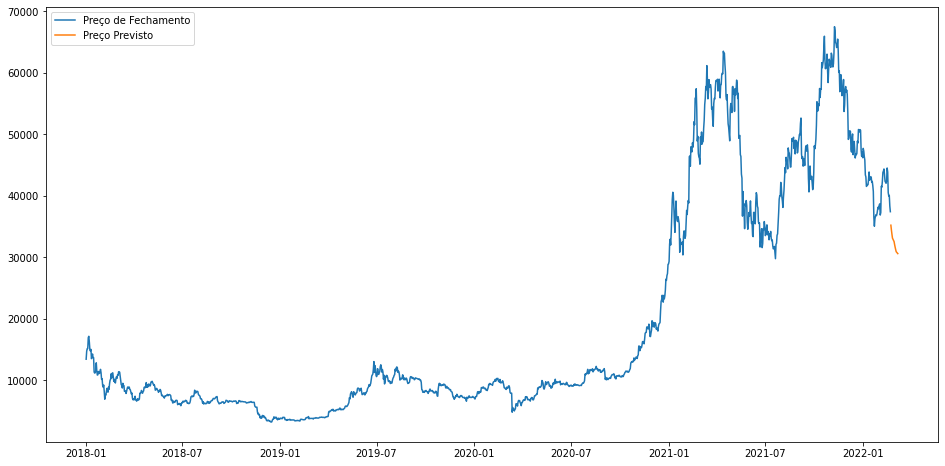

In [121]:
# plotando o gráfico

plt.figure(figsize=(16,8))
plt.plot(dataframe_dados_selecionados["Último"])
plt.plot(df_forecast["Valor Previsto"])
plt.legend(["Preço de Fechamento", "Preço Previsto"])
plt.show()